In [1]:
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

from datasets import load_dataset

import torch
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,)
# Load the model
model = AutoModelForCausalLM.from_pretrained("fine_tuned/data_new_ft_phi3LoRA_full",quantization_config=quantization_config)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("fine_tuned/data_new_ft_phi3LoRA_full")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
import json

dataset_file = "eval_data_june24.json"

with open(dataset_file, "r") as f:
    eval_data = json.load(f)

In [3]:
def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n").format_map(row)

In [4]:
prompts = [prompt_input(row) for row in eval_data]

In [5]:
def pad_eos(ds):
    EOS_TOKEN = "</s>"
    return [f"{row['output']}{EOS_TOKEN}" for row in ds]

In [6]:
outputs = pad_eos(eval_data)
outputs[0]

"['GHR Cleaning and Technical services Company logo', 'carpet cleaning, sofa cleaning, mattress cleaning, maid services', 'office cleaning, apartment cleaning', 'trustworthy and reliable cleaning services', 'contact details GHR Cleaning and Technical services', 'Instagram and Facebook page GHR Cleaning and Technical services']</s>"

In [7]:
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer for bigrams (ROUGE-2)
scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)

def compute_rouge2(predictions, references):
    rouge2_scores = []
    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)['rouge2'].fmeasure
        rouge2_scores.append(score)
    return sum(rouge2_scores) / len(rouge2_scores)

In [ ]:
from tqdm import tqdm
rouge2_score = []
for i in tqdm(range(len(prompts))):
    inputs = tokenizer(prompts[i], return_tensors='pt').to('cuda')
    outputs_model = model.generate(
    inputs.input_ids, 
    max_new_tokens=50,  # Increase the maximum number of new tokens
    num_beams=2,  # Reduce the number of beams to speed up generation
    num_return_sequences=1,  # Generate only one sequence
    no_repeat_ngram_size=2,  # Prevent repetition
    do_sample=False,  # Disable sampling for faster generation
    )
    generated_text = tokenizer.decode(outputs_model[0], skip_special_tokens=True)
    # Find the position of '</s>' in the generated text
    end_index = generated_text.find('</s>')

    # Extract the text up to the '</s>' tag
    generated_text = generated_text[:end_index]
    first_index = generated_text.find("### Response:")+14
    generated_text = [item.strip() for item in generated_text[first_index:].strip("[]").split(',')]
    outpu = [item.strip() for item in outputs[i][:-4].strip("[]").split(',')]    
    # Compute ROUGE-2 score
    rouge2 = compute_rouge2(generated_text, outpu)
    rouge2_score.append(rouge2)

 69%|██████▉   | 555/799 [1:44:40<28:25,  6.99s/it]

In [10]:
print(len(rouge2_score))

799


In [11]:
print(rouge2_score)

[0.0, 0.14583333333333331, 0.0303030303030303, 0.2875, 0.14285714285714288, 0.0816326530612245, 0.0, 0.14285714285714288, 0.08333333333333333, 0.05555555555555556, 0.0, 0.0, 0.3076923076923077, 0.280952380952381, 0.45454545454545453, 0.14814814814814814, 0.42000000000000004, 0.18055555555555555, 0.15, 0.16, 0.07142857142857144, 0.4444444444444444, 0.2678571428571429, 0.16666666666666666, 0.16666666666666669, 0.13714285714285715, 0.25, 0.22545454545454544, 0.08333333333333333, 0.08333333333333333, 0.514920634920635, 0.13392857142857145, 0.15, 0.0, 0.16666666666666666, 0.2121212121212121, 0.23809523809523808, 0.06666666666666668, 0.275, 0.0, 0.16333333333333333, 0.2333333333333333, 0.11636363636363636, 0.0, 0.03333333333333333, 0.0625, 0.16666666666666666, 0.14583333333333331, 0.08888888888888889, 0.0, 0.0, 0.05714285714285715, 0.2896825396825397, 0.14583333333333331, 0.0, 0.09523809523809523, 0.30952380952380953, 0.13333333333333333, 0.125, 0.1928571428571429, 0.0, 0.08333333333333333, 

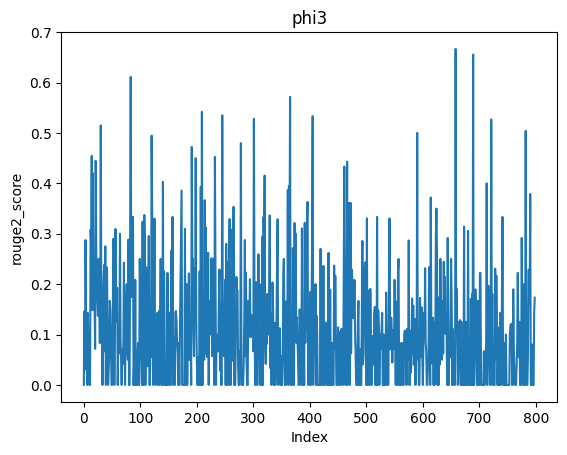

In [14]:
# Create a line plot
plt.plot(rouge2_score)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('rouge2_score')
plt.title('phi3')

# Show the plot
plt.show()

In [13]:
count =0
for i in rouge2_score:
    if i!=0.0:
        count+=1
print(count,len(rouge2_score) - count)

542 257


In [15]:

inputs = tokenizer(prompts[0], return_tensors='pt')
outputs_model = model.generate(
inputs.input_ids, 
max_new_tokens=50,  # Increase the maximum number of new tokens
num_beams=2,  # Reduce the number of beams to speed up generation
num_return_sequences=1,  # Generate only one sequence
no_repeat_ngram_size=2,  # Prevent repetition
do_sample=False,  # Disable sampling for faster generation
)
generated_text = tokenizer.decode(outputs_model[0], skip_special_tokens=True)
# Find the position of '</s>' in the generated text
end_index = generated_text.find('</s>')

# Extract the text up to the '</s>' tag
generated_text = generated_text[:end_index]
first_index = generated_text.find("### Response:")+14
generated_text = [item.strip() for item in generated_text[first_index:].strip("[]").split(',')]

outpu = [item.strip() for item in outputs[0][:-4].strip("[]").split(',')]    
print(generated_text, outpu)
# Compute ROUGE-2 score
rouge2 = compute_rouge2(generated_text, outpu)
print(rouge2)

["'GHR Services logo'", "'carpet and sofas cleaned by professionals'", '"cleaning office space"', "'satisfied customer'", "''5458269'", '\'"GHRC Services" on social media\''] ["'GHR Cleaning and Technical services Company logo'", "'carpet cleaning", 'sofa cleaning', 'mattress cleaning', "maid services'", "'office cleaning", "apartment cleaning'", "'trustworthy and reliable cleaning services'", "'contact details GHR Cleaning and Technical services'", "'Instagram and Facebook page GHR Cleaning and Technical services'"]
0.0
